In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import random
from tqdm import tqdm
import shutil
import time
import copy

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


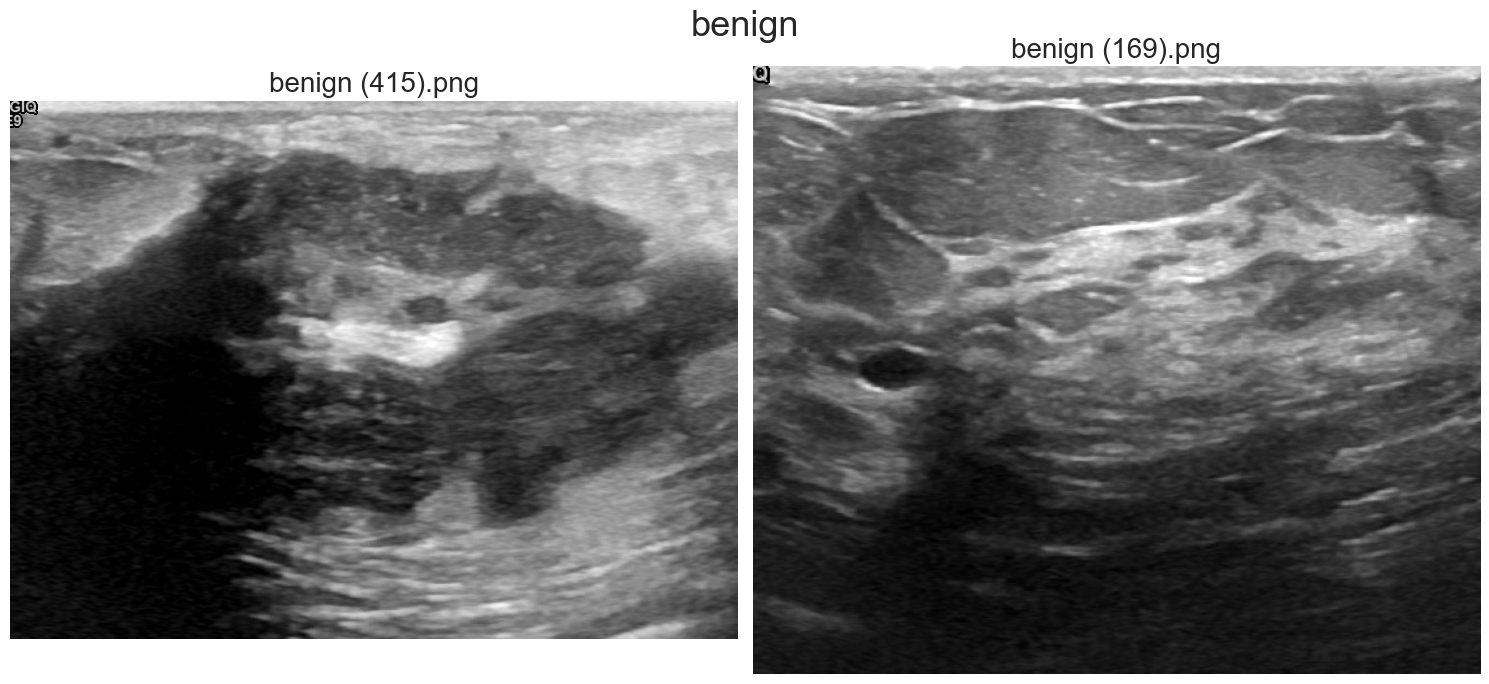

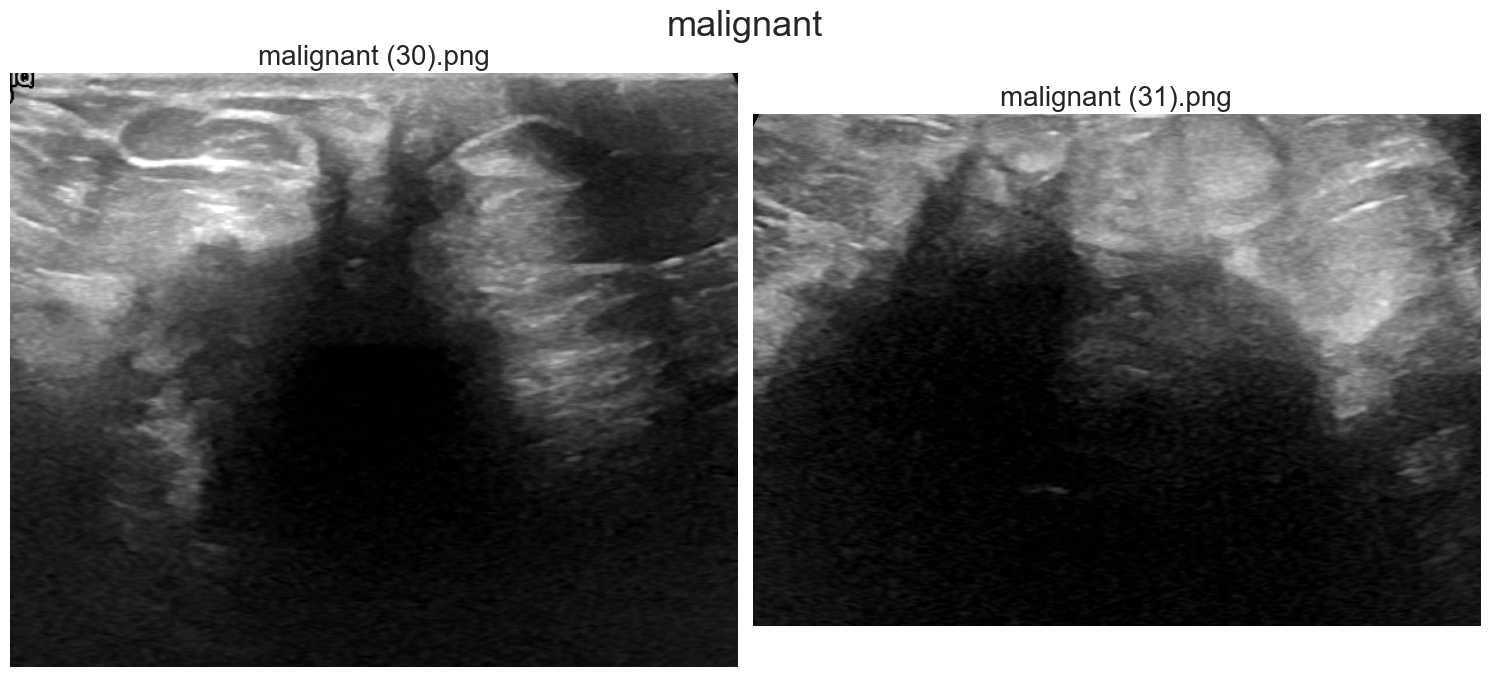

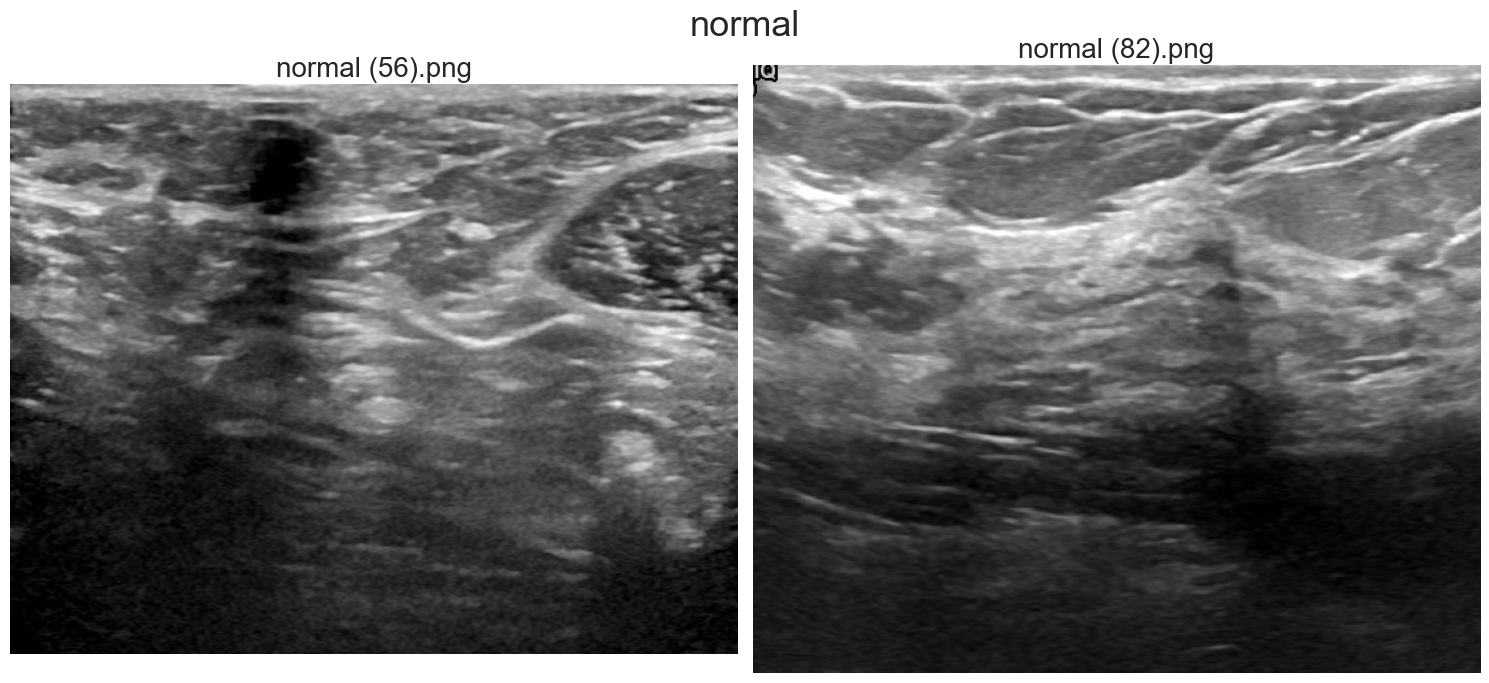

In [4]:
data_dir = r'E:\Eden\OnlineDataset\archive\Images'
class_names = ['benign', 'malignant', 'normal']

for category in class_names:
    path = os.path.join(data_dir, category)
    fig, axes = plt.subplots(1,2, figsize=(15, 7))
    for i in range(2):
        img = np.random.choice(os.listdir(path))
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img_array, cmap='gray')
        axes[i].set_title(img, fontsize=20)
        axes[i].axis('off')

    plt.suptitle(category, fontsize=26)
    plt.tight_layout()

    plt.show()


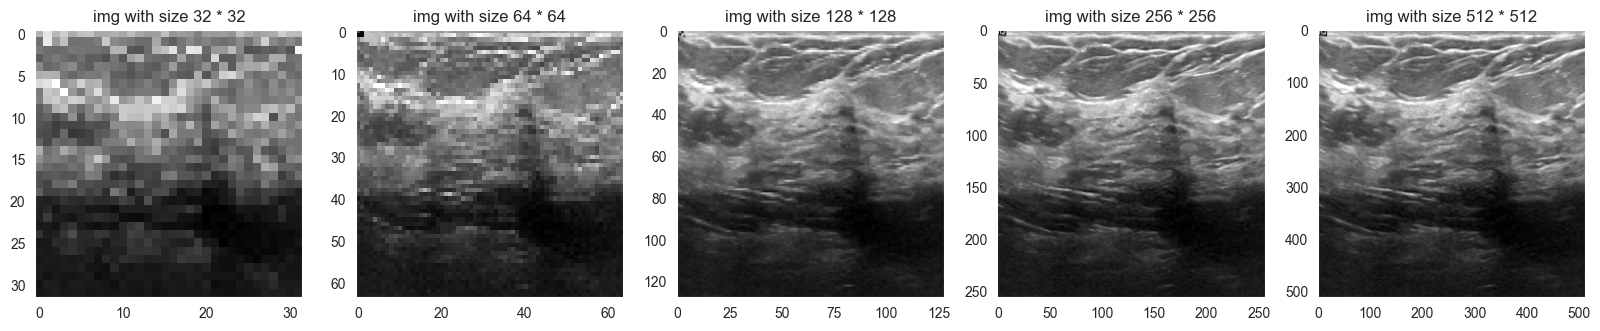

In [5]:
img_sz = 2**np.array([5, 6, 7, 8, 9])
plt.figure(figsize=(20, 5))

for i, sz in enumerate(img_sz):
    new_array = cv2.resize(img_array, (sz, sz))
    plt.subplot(1, len(img_sz), i+1)
    plt.imshow(new_array, cmap='gray')
    plt.title(f"img with size {sz} * {sz}")
    plt.grid()

plt.show()


In [6]:
#size (256*256) is okay
img_sz=256

In [7]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            labels.append(label)
            file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})


In [8]:
# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data['Label'], random_state=159)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=159)

split_data_path = r'E:\Eden\OnlineDataset\archive\Dataset_Images'
# Define the paths for the train, validation, and test directories
train_dir = os.path.join(split_data_path, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
    for label in set(labels):
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    # Copy the images to the corresponding directories
    time.sleep(2)
    for _, row in train_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(train_dir, label))

val_dir = os.path.join(split_data_path,'validation')
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for label in set(labels):
        os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    time.sleep(2)
    for _, row in val_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(val_dir, label))

test_dir = os.path.join(split_data_path,'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
    for label in set(labels):
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    time.sleep(2)
    for _, row in test_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(test_dir, label))

In [9]:
# Initialize sums
psum = np.zeros(3)
psum_sq = np.zeros(3)
count = 0

for path in data['Image_Path']:
    img = np.array(Image.open(path).convert('RGB')) / 255.0  # Normalize to [0,1]
    psum += img.sum(axis=(0, 1))
    psum_sq += (img ** 2).sum(axis=(0, 1))
    count += img.shape[0] * img.shape[1]

mean = psum / count
var = (psum_sq / count) - (mean ** 2)
std = np.sqrt(var)

print("Mean:", mean)
print("Std:", std)

Mean: [0.32823274 0.32822795 0.32818426]
Std: [0.22100208 0.22100282 0.22098634]


In [10]:
# Define the minority classes in your dataset
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    transforms.RandomRotation(15, expand=False, center=None),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_sz),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.65) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(img_sz),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_sz),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [11]:
# Train
# List the subdirectories (benign, malignant, normal)
subdirectories = class_names.copy()

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

# Val
# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(val_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

# Test
# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")


Train benign: 297
Train malignant: 143
Train normal: 90
Validation benign: 74
Validation malignant: 36
Validation normal: 23
test benign: 66
test malignant: 31
test normal: 20


In [12]:
# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(split_data_path, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 530, 'validation': 133, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


In [13]:
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    # since = time.time()
    #
    # best_model_wts = copy.deepcopy(model.state_dict())
    # best_loss = float('inf')  # Initialize best_loss with a large value
    # consecutive_epochs_without_improvement = 0
    #
    # # Lists to store training and validation losses
    # train_losses, train_losses_running, train_acc = [], [], []
    # val_losses, val_losses_running, val_acc = [], [], []
    #
    # for epoch in range(num_epochs):
    #     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    #     print('-' * 10)
    #
    #     # Each epoch has a training and validation phase
    #     for phase in ['train', 'validation']:
    #         if phase == 'train':
    #             model.train()  # Set model to training mode
    #         else:
    #             model.eval()   # Set model to evaluate mode
    #
    #         running_loss = 0.0
    #         running_corrects = 0
    #
    #         # Iterate over data
    #         for inputs, labels in dataloaders[phase]:
    #             inputs = inputs.to(device)
    #             labels = labels.to(device)
    #
    #             # Zero the parameter gradients
    #             optimizer.zero_grad()
    #
    #             # Forward
    #             with torch.set_grad_enabled(phase == 'train'):
    #                 outputs = model(inputs)
    #                 _, preds = torch.max(outputs, 1)
    #                 loss = lossFunction(outputs, labels)
    #
    #                 # Backward + optimize only if in training phase
    #                 if phase == 'train':
    #                     loss.backward()
    #                     optimizer.step()
    #
    #             # Append training loss here
    #             if phase == 'train':
    #                 train_losses_running.append(loss.item())  # Append training loss
    #             else:
    #                 val_losses_running.append(loss.item())  # Append validation loss
    #
    #             # Statistics
    #             running_loss += loss.item() * inputs.size(0)
    #             running_corrects += torch.sum(preds == labels.data).cpu()
    #
    #         if phase == 'train':
    #             scheduler.step()
    #
    #         epoch_loss = running_loss / dataset_sizes[phase]
    #         epoch_acc = running_corrects.double() / dataset_sizes[phase]
    #
    #         print('{} Loss: {:.4f} Acc: {:.4f}'.format(
    #             phase, epoch_loss, epoch_acc))
    #
    #         # Early stopping: Check if validation loss improved
    #         if phase == 'validation':
    #             if epoch_loss < best_loss:
    #                 best_loss = epoch_loss
    #                 best_model_wts = copy.deepcopy(model.state_dict())
    #                 consecutive_epochs_without_improvement = 0
    #             else:
    #                 consecutive_epochs_without_improvement += 1
    #
    #             val_losses.append(epoch_loss)
    #             val_acc.append(epoch_acc)
    #         else:
    #             train_losses.append(epoch_loss)
    #             train_acc.append(epoch_acc)
    #
    #     # Check if early stopping criteria are met
    #     if consecutive_epochs_without_improvement >= patience:
    #         print(f"Early stopping after {epoch} epochs")
    #         break
    #
    #     print()
    #
    # time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))
    # print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    # Plot the confusion matrix with label names
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [17]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(DEVICE)


C:\Users\edenkor\PyCharmMiscProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

In [20]:
model_fineTuning = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, DEVICE, num_epochs=30, patience=5
)
torch.save(model_fineTuning, os.path.join(data_dir,"Resnet_fineTuning.pth"))

Epoch 0/29
----------
train Loss: 0.7685 Acc: 0.6642
validation Loss: 0.7810 Acc: 0.7444

Epoch 1/29
----------
train Loss: 0.5111 Acc: 0.8170
validation Loss: 0.5192 Acc: 0.7895

Epoch 2/29
----------
train Loss: 0.4411 Acc: 0.8358
validation Loss: 0.4613 Acc: 0.8195

Epoch 3/29
----------
train Loss: 0.4479 Acc: 0.8283
validation Loss: 0.4174 Acc: 0.8496

Epoch 4/29
----------
train Loss: 0.3624 Acc: 0.8660
validation Loss: 0.5193 Acc: 0.7594

Epoch 5/29
----------
train Loss: 0.2659 Acc: 0.9038
validation Loss: 0.3850 Acc: 0.8271

Epoch 6/29
----------
train Loss: 0.2498 Acc: 0.9113
validation Loss: 0.3812 Acc: 0.8346

Epoch 7/29
----------
train Loss: 0.1634 Acc: 0.9509
validation Loss: 0.3439 Acc: 0.8496

Epoch 8/29
----------
train Loss: 0.1827 Acc: 0.9453
validation Loss: 0.3897 Acc: 0.8647

Epoch 9/29
----------
train Loss: 0.1530 Acc: 0.9642
validation Loss: 0.3442 Acc: 0.8722

Epoch 10/29
----------
train Loss: 0.1252 Acc: 0.9642
validation Loss: 0.3507 Acc: 0.8571

Epoch 11/

NameError: name 'label_names' is not defined

<Figure size 500x300 with 0 Axes>

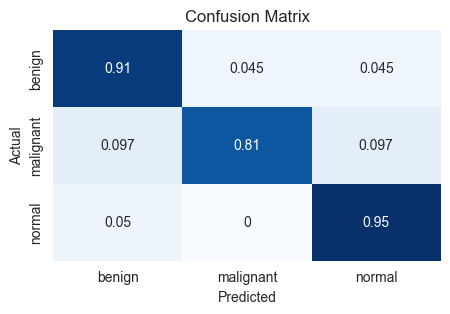

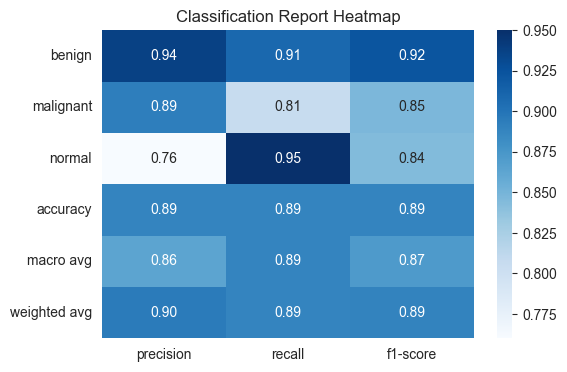

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.937500   0.892857  0.760000  0.888889   0.863452      0.895330
recall     0.909091   0.806452  0.950000  0.888889   0.888514      0.888889
f1-score   0.923077   0.847458  0.844444  0.888889   0.871660      0.889600


In [109]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred, normalize='true')

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows


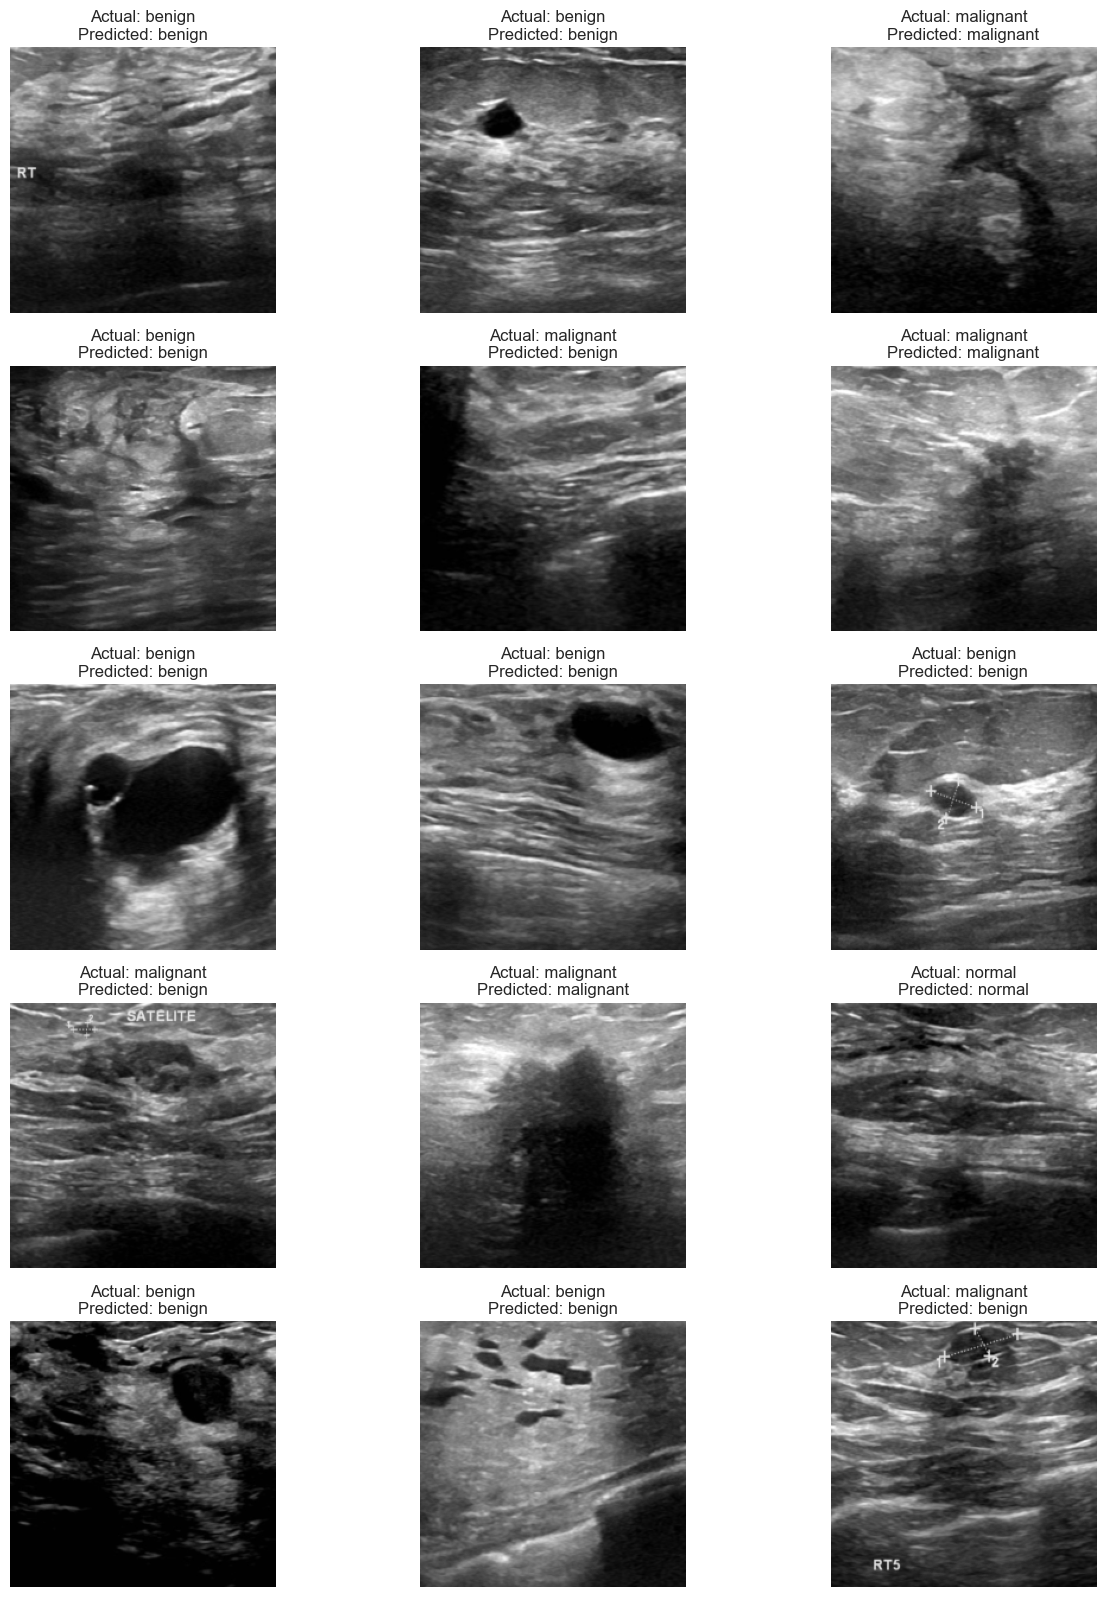

In [63]:
# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(DEVICE)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()


In [21]:
training_data = []

def create_training_data():
    for file in files_names:
        path = os.path.join(folder_name, file)
        class_num = files_names.index(file)
        print(file,class_num)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_sz, img_sz))  # Include resizing
            training_data.append([new_array, class_num])

create_training_data()


benign 0


100%|██████████| 437/437 [00:06<00:00, 66.15it/s]


malignant 1


100%|██████████| 210/210 [00:02<00:00, 71.57it/s]


normal 2


100%|██████████| 133/133 [00:02<00:00, 62.47it/s]


In [23]:
# for i in range(5):
#     print("Class number for image", i+1, ":", training_data[i][1])
#
# for i in range(-1, -6, -1):
#     print("Class number for image", len(training_data) + i + 1, ":", training_data[i][1])


Class number for image 1 : 0
Class number for image 2 : 0
Class number for image 3 : 0
Class number for image 4 : 0
Class number for image 5 : 0
Class number for image 780 : 2
Class number for image 779 : 2
Class number for image 778 : 2
Class number for image 777 : 2
Class number for image 776 : 2


In [24]:
random.shuffle(training_data)

for i in range(30):
    print(f"Sample {i+1}:")
    print("Class number:", training_data[i][1],"\n")

Sample 1:
Class number: 0 

Sample 2:
Class number: 1 

Sample 3:
Class number: 1 

Sample 4:
Class number: 0 

Sample 5:
Class number: 0 

Sample 6:
Class number: 0 

Sample 7:
Class number: 0 

Sample 8:
Class number: 0 

Sample 9:
Class number: 0 

Sample 10:
Class number: 1 

Sample 11:
Class number: 2 

Sample 12:
Class number: 0 

Sample 13:
Class number: 0 

Sample 14:
Class number: 0 

Sample 15:
Class number: 0 

Sample 16:
Class number: 0 

Sample 17:
Class number: 0 

Sample 18:
Class number: 1 

Sample 19:
Class number: 0 

Sample 20:
Class number: 0 

Sample 21:
Class number: 0 

Sample 22:
Class number: 0 

Sample 23:
Class number: 2 

Sample 24:
Class number: 0 

Sample 25:
Class number: 0 

Sample 26:
Class number: 0 

Sample 27:
Class number: 0 

Sample 28:
Class number: 2 

Sample 29:
Class number: 0 

Sample 30:
Class number: 0 



In [29]:
X=[]
y=[]
for img,label in training_data:
    X.append(img)
    y.append(label)

X=np.array(X)
y=np.array(y)

print(X.shape)
print(y.shape)

(780, 300, 300)
(780,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=159)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(624, 300, 300)
(624,)
(156, 300, 300)
(156,)


[[0.56862745 0.63137255 0.63921569 ... 0.59215686 0.63137255 0.65098039]
 [0.5254902  0.52941176 0.54117647 ... 0.43529412 0.47058824 0.4745098 ]
 [0.56470588 0.53333333 0.54117647 ... 0.33333333 0.3372549  0.34509804]
 ...
 [0.05098039 0.05098039 0.0745098  ... 0.04313725 0.05882353 0.05490196]
 [0.05490196 0.05490196 0.03137255 ... 0.03921569 0.03921569 0.02745098]
 [0.09019608 0.07843137 0.04313725 ... 0.04313725 0.03137255 0.03529412]]


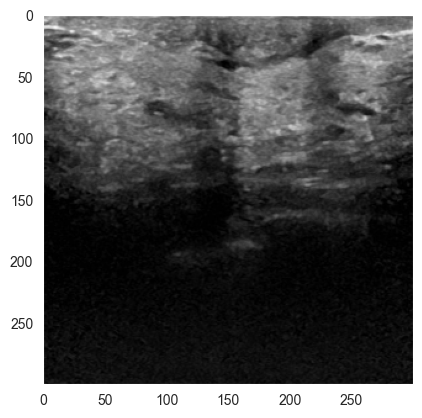

In [43]:
X_train = X_train/255
X_test = X_test/255

print(X_train[0])

plt.imshow(X_train[0],cmap='gray')
plt.grid()
plt.show()

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, img_sz):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # Equivalent to keras.layers.Flatten(input_shape=(img_sz,img_sz))
            nn.Linear(img_sz*img_sz, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.Softmax(dim=1)  # Use nn.Softmax(dim=1) if this is multi-class classification
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(img_sz,img_sz)),
                          keras.layers.Dense(256, activation='relu'),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(32, activation='relu'),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(8, activation='relu'),
                          keras.layers.Dense(3, activation='sigmoid')
])